In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Raw data is contained in '../Data/Raw' directory
# Processed data will be written to '../Data/Processed'
# This cell lists all files under the input directory

import os
INPUT_DIR = os.path.join(os.path.dirname(os.getcwd()), 'Data', 'Raw')
OUTPUT_DIR = os.path.join(os.path.dirname(os.getcwd()), 'Data', 'Processed')
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Raw\Books.csv
c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Raw\Ratings.csv
c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Raw\Users.csv


This notebook is exploring the dataset. There are 3 csv files, describing book ratings, users, and books. Let us look more closely at the data.

In [6]:
ratings_df = pd.read_csv(os.path.join(INPUT_DIR, 'Ratings.csv'))
print(ratings_df.info())
print(ratings_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


As we see, the ratings table has 3 columns - user-ID, ISBN, and book rating: 
* User-ID is the unique identifier of the user;
* ISBN stands for the International Standard Book Number and is a numeric commercial book identifier that is intended to be unique. There are several diferent standards for ISBN, from the head of our table it seems that here the 10-digit format is used but it is better that we check this. Moreover, it seems that some of the ISBNs are missing the last "check" digit and have "X" in its place.
* Book-rating is a number, judging by the first few columns it is probably an integer from 0 to 10, we need to check that, too.

<AxesSubplot:>

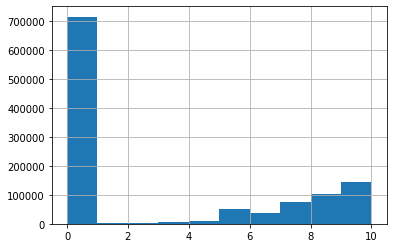

In [7]:
ratings_df['Book-Rating'].hist()

Indeed, the histogram of the Book-Rating column above shows that there are only ratings from 0 to 10 and they are integers since that column only contains int64 entities. 0 is implicit rating, meaning that the person didn't rate the book but rather showed some interest in it via clicking on it or checking the book details. The numbers from 1 to 10 are explicit ratings, with higher number indicating higher appreciation of the book. We will first deal with the explicit ratings, so let us delete the rows with 0 rating for now. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB
None


<AxesSubplot:>

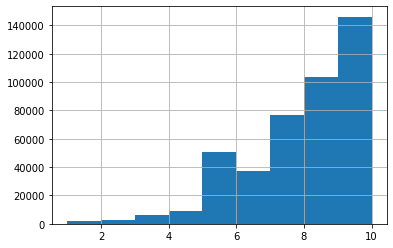

In [8]:
ratings_df_no_zeroes = ratings_df[ratings_df['Book-Rating'] != 0]
print(ratings_df_no_zeroes.info())
ratings_df_no_zeroes['Book-Rating'].hist(bins=range(1,11))

Now let us move our attention to the ISBN column and check if all of the numbers their are valid 10-digit ISBN codes, with either correct or missing check digit.

In [9]:
def is_valid_13(code): 
    """Checks if the code is a valid 13-digit ISBN"""
    if len(code) != 13:
        return False
    if not code.isdigit():
        return False
    sum = 0
    for i in range(0, 13, 2):
        sum += int(code[i])
    for i in range(1, 13, 2):
        sum += 3 * int(code[i])
    return sum % 10 == 0

    
def is_valid_10(code): 
    """Checks if the code is a valid 10-digit ISBN"""
    if len(code) != 10:
        return False
    if not code[:-1].isdigit():
        return False
    if not (code[-1].isdigit() or code[-1] in ['x', 'X']):
        return False
    sum = 0
    for i in range(9):
        sum += (10 - i) * (int(code[i]))
    if code[-1] in ['X', 'x']:
        sum += 10
    else:
        sum += int(code[-1])
    return sum % 11 == 0

def is_valid_9(code): 
    """Checks if the code is a valid 9-digit ISBN"""
    if len(code) != 9:
        return False
    return is_valid_10('0'+code)

def is_valid(code):
    """Checks if the code is a valid 9-, 10, or 13-digit ISBN"""
    if len(code) == 9:
        return is_valid_9(code)
    if len(code) == 10:
        return is_valid_10(code)
    if len(code) == 13:
        return is_valid_13(code)
    return False

non_valid_ISBN = ratings_df[ratings_df['ISBN'].apply(is_valid) != True]
print(non_valid_ISBN.info())
print(non_valid_ISBN.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13592 entries, 9 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      13592 non-null  int64 
 1   ISBN         13592 non-null  object
 2   Book-Rating  13592 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 424.8+ KB
None
     User-ID         ISBN  Book-Rating
9     276745    342310538           10
40    276762    342662429            0
54    276762   B0000BLD7X            0
55    276762  N3453124715            4
143   276822   0699854289           10


It seems there are quite a few books with an invalid ISBN even though the dataset description promised otherwise! The following code gives us a dataframe of ratings for books with valid ISBN.

In [10]:
ratings_df_valid = ratings_df[ratings_df['ISBN'].apply(is_valid)]
print(ratings_df_valid.info())
print(ratings_df_valid.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1136188 entries, 0 to 1149778
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1136188 non-null  int64 
 1   ISBN         1136188 non-null  object
 2   Book-Rating  1136188 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 34.7+ MB
None
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


We can now write the information about the ratings into a csv file.

In [11]:
ratings_df_valid.to_csv(os.path.join(OUTPUT_DIR, 'Ratings_valid_ISBN.csv'), index=False)

We move out attention to the book csv table right now, that should contain some information about the books.

In [12]:
books_df = pd.read_csv(os.path.join(INPUT_DIR, 'Books.csv'))
print(books_df.info())
print(books_df.head())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9232\3948251361.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv(os.path.join(INPUT_DIR, 'Books.csv'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0

The books table contains 8 columns:
* ISBN                 
* Book-Title           
* Book-Author          
* Year-Of-Publication  
* Publisher            
* Image-URL-S          
* Image-URL-M          
* Image-URL-L

Publisher, book author and large image are missing for a couple of books, we will remove those books. Clicking on the URLs in the Image-URL columns we understand that those are the images for covers of the books. Even though it might contain some valuable information, we are not going to judge a book by its cover (at least for now!), so we will drop the image columns. 

In [13]:
books_df_no_images = books_df.drop(columns = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])
books_df_no_images = books_df_no_images.dropna()
print(books_df_no_images.info())
print(books_df_no_images.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271357 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271357 non-null  object
 1   Book-Title           271357 non-null  object
 2   Book-Author          271357 non-null  object
 3   Year-Of-Publication  271357 non-null  object
 4   Publisher            271357 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB
None
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  
0    Mark P

The following checks if the ISBNs are valid and creates a dataframe for the rows with invalid ones.

In [14]:
books_invalid_ISBN = books_df_no_images[books_df_no_images['ISBN'].apply(is_valid) != True]
print(books_invalid_ISBN.info())
print(books_invalid_ISBN.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 6291 to 270688
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ISBN                 118 non-null    object
 1   Book-Title           118 non-null    object
 2   Book-Author          118 non-null    object
 3   Year-Of-Publication  118 non-null    object
 4   Publisher            118 non-null    object
dtypes: object(5)
memory usage: 5.5+ KB
None
             ISBN                                         Book-Title  \
6291   B00009ANY9                                         Cane River   
10272  B0000A2U93                                           Carmilla   
11185  B0000633PU        The Story of Aladdin and the Wonderful Lamp   
13862  B00007FYKO  Bloodcurdling Tales of Horror and the Macabre:...   
13865  B00009APKU                                          Moby Dick   

                   Book-Author Year-Of-Publication                  P

There are some 118 books with an invalid ISBN. Quick googling suggests that those are not ISBN at all and in fact are ASIN, which stands for Amazon Standard Identification Number. While that could have been ok and indeed we saw some of the similar numbers in the ratings dataframe, it seems wiser to remove books with ASIN instead of ISBN altogether as it is just a small fraction of books and it creates confusion. The following cell does just that.

In [15]:
books_valid_ISBN = books_df_no_images[books_df_no_images['ISBN'].apply(is_valid)]
print(books_valid_ISBN.info())
print(books_valid_ISBN.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271239 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271239 non-null  object
 1   Book-Title           271239 non-null  object
 2   Book-Author          271239 non-null  object
 3   Year-Of-Publication  271239 non-null  object
 4   Publisher            271239 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB
None
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  
0    Mark P

For some reason the year of publication has type object instead of int. The next cell converts the years to integers and plots a histogram of the year of publication in the dataset.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9232\692656067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_valid_ISBN['Year-Of-Publication'] = pd.to_numeric(books_valid_ISBN['Year-Of-Publication'], errors='coerce')


<AxesSubplot:>

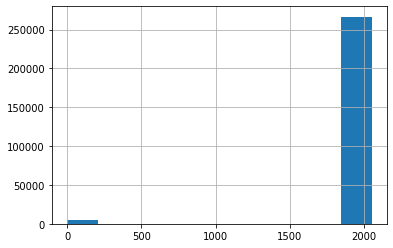

In [16]:
books_valid_ISBN['Year-Of-Publication'] = pd.to_numeric(books_valid_ISBN['Year-Of-Publication'], errors='coerce')
books_valid_ISBN = books_valid_ISBN.dropna()
books_valid_ISBN['Year-Of-Publication'].hist()

It seems that for some books the year of publication is unknown and is set to 0. We will drop those books and try plotting a histogram again.

<AxesSubplot:>

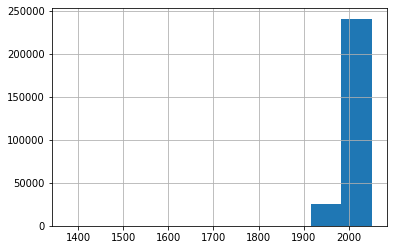

In [17]:
books_valid_ISBN_known_year = books_valid_ISBN[books_valid_ISBN['Year-Of-Publication'] != 0]
books_valid_ISBN_known_year['Year-Of-Publication'].hist()

It looks like there are no books published before 1900 in our dataset (which makes sense as you probably cannot buy such books on Amazon!). Just in case, we check the earliest publication year, and replot the histogram accordingly.

1376.0 2050.0


<AxesSubplot:>

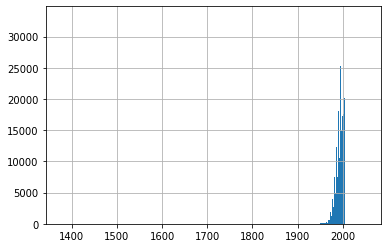

In [18]:
min_year = min(books_valid_ISBN_known_year['Year-Of-Publication'])
max_year = max(books_valid_ISBN_known_year['Year-Of-Publication'])
print(min_year, max_year)
n_bins = int(np.sqrt(len(books_valid_ISBN_known_year['Year-Of-Publication'])))
books_valid_ISBN_known_year['Year-Of-Publication'].hist(bins=n_bins)

Something strange is going on! Publishing started in 1439, but we have a book with 1376 as year of publication. Moreover, this dataset was last updated in 2020 but there is a book supposedly published in 2050. Let us check how many books there are in the dataset that are published before 1900 or after 2020.

In [19]:
books_abnormal_year = books_valid_ISBN_known_year[(books_valid_ISBN_known_year['Year-Of-Publication'] < 1900) |
                                                  (books_valid_ISBN_known_year['Year-Of-Publication'] > 2020)]
print(books_abnormal_year.info())
print(books_abnormal_year)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 37487 to 260974
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 18 non-null     object 
 1   Book-Title           18 non-null     object 
 2   Book-Author          18 non-null     object 
 3   Year-Of-Publication  18 non-null     float64
 4   Publisher            18 non-null     object 
dtypes: float64(1), object(4)
memory usage: 864.0+ bytes
None
              ISBN                                         Book-Title  \
37487   0671746103  MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...   
55676   0671791990  MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...   
78168   0870449842                                   Crossing America   
80264   0140301690  Alice's Adventures in Wonderland and Through t...   
97826   0140201092      Outline of European Architecture (Pelican S.)   
116053  0394701658                      

It is not too many books with a strange year. All of the books published early seem to have a correct publication date, but we would still delete the books published before 1810, as it is only 4 of them. As for the books with a publishing year over 2020, that is for sure incorrect and we will get rid of them as well.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266656 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 266656 non-null  object 
 1   Book-Title           266656 non-null  object 
 2   Book-Author          266656 non-null  object 
 3   Year-Of-Publication  266656 non-null  float64
 4   Publisher            266656 non-null  object 
dtypes: float64(1), object(4)
memory usage: 12.2+ MB
None
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author  Year-Of-Publication                   Pub

<AxesSubplot:>

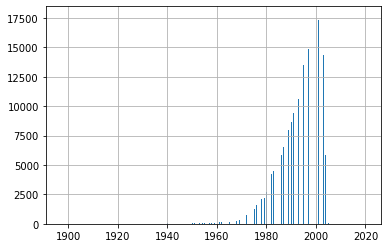

In [20]:
books_valid_ISBN_known_year = books_valid_ISBN_known_year[(books_valid_ISBN_known_year['Year-Of-Publication'] > 1810) &
                                                  (books_valid_ISBN_known_year['Year-Of-Publication'] <= 2020)]
print(books_valid_ISBN_known_year.info())
print(books_valid_ISBN_known_year.head())
books_valid_ISBN_known_year['Year-Of-Publication'].hist(bins=n_bins)

Now let us look at the publishers. We will group the books by the publishers and sort it by the amount of books.

In [21]:
publishers_sorted = books_valid_ISBN_known_year.groupby('Publisher')['ISBN'].count().sort_values(ascending=False)
print(len(publishers_sorted))
print(publishers_sorted.head(15))

16385
Publisher
Harlequin                   7535
Silhouette                  4220
Pocket                      3870
Ballantine Books            3764
Bantam Books                3642
Scholastic                  3156
Simon &amp; Schuster        2959
Penguin Books               2843
Berkley Publishing Group    2767
Penguin USA                 2714
Warner Books                2701
Harpercollins               2518
Fawcett Books               2257
Signet Book                 2067
Random House Inc            2045
Name: ISBN, dtype: int64


So, in our dataset there are ~16k different publishers for our 266.5k books. What are the top 5 publishers?
* **Harlequin** is a famous romance and women's fiction pusblisher. It was founded in 1949 and became a division of **HarperCollins** in 2014. 
* **Silhouette** was formed in 1980 to fill the gap opened when **Harlequin** terminated its distribution contract with **Simon & Schuster** and **Pocket Books** in 1976. Similar to **Harlequin**, they published romance novels, but the authors were encouraged to experiment with the genre. In 1984, **Harlequin** purchased **Silhouette** from **Simon & Schuster**.
* **Pocket** is a division of **Simon & Schuster** that specializes in paperback books, founded in 1939. It publishes various genre, from novelizations of movies to the works of Shakespeare.
* **Ballantine Books** was founded in 1952 and acquired by **Random House** in 1973. It is known for its paperback science fiction and fantasy, especially their paperback edition of J.R.R.Tolkien's *The Lord of The Rings*, which included a message on the back cover from Tolkien himself urging consumers to buy Ballantine's version and boycott "unauthorized editions" (i.e. the version from Ace Books). 
* **Bantam Books**, owned by **Random House** now, was founded in 1945 and first published mostly reprints of hardcover books. They publish very different books, including classics, sci-fi, and children's books.   


This information about the publishers suggests that while some publishers focus on a specific genre, the others might just print cheap paperbacks of all sorts. We could use it later for recommendations, adding features such as genre and paperback/hardcover.

We write our cleaned up dataframe to csv file. 

In [22]:
books_valid_ISBN_known_year.to_csv(os.path.join(OUTPUT_DIR, 'Books_valid_ISBN_known_year_no_images.csv'), index=False)

Finally, let us check out the users table.

In [23]:
users_df = pd.read_csv(os.path.join(INPUT_DIR, 'Users.csv'))
print(users_df.info())
print(users_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None
   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN


So, the users table contains information about ~280k users anonymised with the User-ID, with location and age. The "Location" column seems to contain information in the form "place, region, country", although "moscow, yukon territory, russia" seems wrong, considering that Yukon territory is in Canada very far from the Russian capital (it could be some other Moscow, of course, but in Russia there is only one Moscow). We next check how many users have missing info.

In [24]:
for column in ['Location', 'Age']:
    print(column, users_df[column].isna().sum())

Location 0
Age 110762


A bit less that half of the users do not have age specified. For those who does, let us see the amount of users for every age, sorted from high to low by the amount of people of that age.

In [25]:
ages = users_df.groupby('Age')['User-ID'].count().sort_values(ascending=False)
print(ages)

Age
24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
         ... 
159.0       1
162.0       1
168.0       1
172.0       1
244.0       1
Name: User-ID, Length: 165, dtype: int64


Seems that some people have lied about their age, as there are no verified records about someone living over 122 years. Let us check how many people with the supposed age of over 100 we have in the table.

In [26]:
print(len(users_df[users_df['Age']>100]))

366


366 is not that many compared to the size of our table and even if someone is over 100 years, they probably do not buy their books on Amazon. We will remove age for those people, and then look at the histogram for the age of the users.

<AxesSubplot:>

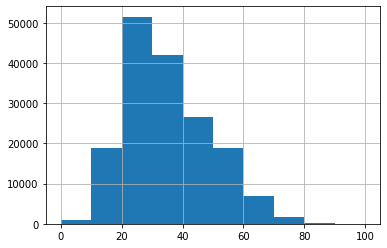

In [27]:
users_df.loc[users_df['Age'] > 100, 'Age'] = np.nan
users_df['Age'].hist()

This looks reasonable. Now let us deal with the location column. First of all, let us create a new column that contains only the country. It seems that the country is the last part of the location, after the last comma, let us separate that and put it in its own column. We will then group the data by country and see how many users are there from each country.

In [28]:
users_df['Country'] = users_df['Location'].apply(lambda x: x.split(",")[-1].strip())
users_by_country = users_df.groupby('Country')['User-ID'].count().sort_values(ascending=False)
print(users_by_country)

Country
usa                                    139711
canada                                  21658
united kingdom                          18538
germany                                 17043
spain                                   13147
                                        ...  
madagascar                                  1
macedonia"                                  1
burkinafasu                                 1
los estados unidos de norte america         1
nyhamnsläge                                 1
Name: User-ID, Length: 709, dtype: int64


We see that we found 709 countries. That can't be true, considering there are only 195 countries in the world (even counting some countries like USSR or Yugoslavia that ceased to exist, there couldn't be so many). Let us make a list of distinct countries and look at it, probably there are some typos and non-English names (like "los estados unidos de norte america").

In [29]:
countries = sorted(users_df['Country'].unique())
print(countries)

['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-', '-------', '.', '01776', '02458', '19104', '23232', '30064', '5057chadwick ct.', '85021', '87510', '?ú?{', '\\"n/a\\""', '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr', 'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'andorra"', 'angola', 'antarctica', 'antigua & barbuda', 'antigua and barbuda', 'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australia"', 'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan', 'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belgium"', 'belize', 'bell', 'benin', 'berguedà', 'bermuda', 'bernalillo', 'bfe', 'bhut

Indeed, as we expected, there are many typos and some names are written not in English. Some people are also being humorous and put "far away..." and things like this as the name of their country. First of all, let us get rid of " at the end of the name as this seems to be a common typo.

In [30]:
users_df['Country'] = users_df['Country'].apply(lambda x: x.strip('*\;?&#0123456789 -_."!>'))
countries = sorted(users_df['Country'].unique())
print(countries)
print(len(countries))

['', 'a', 'aaa', 'adsgfdr', 'afganstand holla', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'angola', 'antarctica', 'antigua & barbuda', 'antigua and barbuda', 'aotearoa', 'argentina', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australii', 'austria', 'autralia', 'az', 'azerbaijan', 'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belize', 'bell', 'benin', 'berguedà', 'bermuda', 'bernalillo', 'bfe', 'bhutan', 'bih', 'bkk', 'bladen', 'bolivia', 'bosnia', 'bosnia and herzegovina', 'botswana', 'brasil', 'brazil', 'british virgin islands', 'brunei', 'brunei darussalam', 'bucks', 'bulgaria', 'buncombe', 'burkina faso', 'burkinafasu', 'burlington', 'burma', 'butler', 'c', 'c.a', 'cadd', '

This is a bit better but still not great. Let us strandartize some spellings, like Trinidad and Tobago, USA, and UAE.

In [31]:
spelling_corrections = {'brasil':'brazil', 'burkinafasu':'burkina faso', 'catalonia':'spain', 'catalunya':'spain', 'catalunya spain':'spain', 'catalunya(catalonia)':'spain',
                        'china people`s republic':'china', 'china öð¹ú':'china', 'chinaöð¹ú':'china','prc':'china''prc',
                        'p r china':'china', 'p.r. china':'china', 'p.r.c':'china', 'p.r.china':'china', 'chinaprc':'china',
                        'canada eh':'canada', 'cananda':'canada', 'canda':'canada',
                        'belgi':'belgium', 'belgique':'belgium', 
                        'people`s republic of china':'china',
                        'england':'uk', 'england uk':'uk', 'u k':'uk', 'u.k':'uk',
                        'united kindgdom':'uk', 'united kindgonm':'uk', 'united kingdom':'uk',
                        'geermany':'germany', 'germany':'germany', 'germay':'germany', 
                        'basilicata':'italy', 'basque country':'spain', 'bavaria':'germany',
                        'good old u.s.a':'usa', 'good old usa ':'usa', 'u.s':'usa', 'u.s. of a':'usa', 'u.s.a':'usa',
                        'algérie':'algeria',
                        'l`algérie':'algeria', 'l`italia':'italy', 'la argentina':'argentina', 'la belgique':'belgium', 'la france':'france', 
                        'la suisse':'switzerland', 'la svizzera':'switzerland', 
                        'italia':'italy', 'italien':'italy', 
                        'philippine':'philippines', 'philippinies':'philippines', 'phillipines':'philippines', 'phippines':'philippines',
                        'the philippines':'philippines',
                        'united sates':'usa', 'united staes':'usa', 'united state':'usa', 'united statea':'usa', 
                        'united stated':'usa', 'united stated of america':'usa', 'united states':'usa', 'united states of america':'usa',
                        'u.a.e':'uae', 'united arab emirates':'uae',
                        'the netherlands':'netherlands',
                        's.corea':'south korea', 'republic of korea':'south korea',
                        'isreal':'israel', 'itlay':'italy',
                        'wales':'uk', 'scotland':'uk',
                        'antigua & barbuda':'antigua and barbuda',
                        'australii':'australia', 'autralia':'australia',
                        'turkei':'turkey', 'türkiye':'turkey',
                        'russian federation':'russia',
                        'deutschland':'germany',
                        'ukrain':'ukraine',
                        'sri lanka\\"n/a':'sri lanka', 'srilanka':'sri lanka',
                        'le canada':'canada', 'le madagascar':'madagascar',
                        'espaã±a':'spain', 'espaã?â±a':'spain', 'españa':'spain',
                        'quit':'', 'n/a':'', 'lazio':'italy',
                        'suisse':'switzerland',
                        'milano':'italy', 'mã?â©xico':'mexico', 'méxico':'mexico',
                        'lecce':'italy', 'lombardia':'italy', 'los estados unidos de norte america':'isa', 'madrid':'spain',
                        'sardegna':'italy', 'sardinia':'italy', 'sicilia':'italy', 'toscana':'italy', 'calabria':'italy',
                        'tobago':'trinidad and tobago', 'trinidad':'trinidad and tobago', 'trinidad & tobago':'trinidad and tobago', 'trinidad/tobago':'trinidad and tobago'
                       }

def correcting(country):
    if country in spelling_corrections:
        return spelling_corrections[country]
    return country

users_df['Country'] = users_df['Country'].apply(correcting)
countries = sorted(users_df['Country'].unique())
print(countries)
print(len(countries))

['', 'a', 'aaa', 'adsgfdr', 'afganstand holla', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'angola', 'antarctica', 'antigua and barbuda', 'aotearoa', 'argentina', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'austria', 'az', 'azerbaijan', 'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'barbados', 'baxter', 'bbbzzzzz', 'belarus', 'belgium', 'belize', 'bell', 'benin', 'berguedà', 'bermuda', 'bernalillo', 'bfe', 'bhutan', 'bih', 'bkk', 'bladen', 'bolivia', 'bosnia', 'bosnia and herzegovina', 'botswana', 'brazil', 'british virgin islands', 'brunei', 'brunei darussalam', 'bucks', 'bulgaria', 'buncombe', 'burkina faso', 'burlington', 'burma', 'butler', 'c', 'c.a', 'cadd', 'california', 'cambodia', 'camden', 'cameroon', 'can', 'canada', 'cape may', 'cape town', 'cape verde', 'caribbean sea', 'carter', 'cass', 'cayman 

There are still some typos and regions instead of countries, but let us look again at the top countries by amount of users.

In [32]:
users_by_country = users_df.groupby('Country')['User-ID'].count().sort_values(ascending=False)
print(users_by_country.head(20))

Country
usa            139739
canada          21663
uk              18647
germany         17105
spain           13363
australia       11787
italy           11330
                 4622
france           3521
portugal         3390
new zealand      3120
netherlands      3053
switzerland      1768
brazil           1690
china            1498
sweden           1456
india            1302
austria          1149
malaysia         1125
argentina        1096
Name: User-ID, dtype: int64


It looks like we have a lot of US users which is not surprising considering the data comes from Amazon. Let us check how many people are the only ones in their country. We will then put an empty string as their country since it is not that many people anyway (cannot be more than 500) and this information is not telling us much.

In [33]:
valid_countries = set(users_by_country[users_by_country > 1].index)
print(valid_countries)

{'', 'lesotho', 'portugal', 'iceland', 'albania', 'el salvador', 'lithuania', 'eritrea', 'costa rica', 'romania', 'paraguay', 'haiti', 'san marino', 'canada', 'liberia', 'singapore', 'norway', 'andorra', 'la chine éternelle', 'russia', 'sierra leone', 'jersey', 'cyprus', 'barbados', 'cayman islands', 'euskal herria', 'cape verde', 'slovenia', 'europe', 'guam', 'georgia', 'france', 'malawi', 'saint lucia', 'egypt', 'kazakhstan', 'marshall islands', 'bahrain', 'ireland', 'tajikistan', 'malaysia', 'jordan', 'azerbaijan', 'brunei', 'cuba', 'croatia', 'sweden', 'honduras', 'panama', 'aruba', 'netherlands antilles', 'laos', 'cameroon', 'guinea-bissau', 'fiji', 'palau', 'dominican republic', 'maldives', 'mali', 'serbia and montenegro', 'trinidad and tobago', 'kenya', 'india', 'china', 'venezuela', 'guinea', 'syria', 'uk', 'tunisia', 'czech republic', 'yugoslavia', 'uzbekistan', 'morocco', 'japan', 'antarctica', 'lebanon', 'samoa', 'belgium', 'senegal', 'sao tome and principe', 'israel', 'germ

In [34]:
def set_weird_country_to_null(country):
    if country not in valid_countries:
        return ''
    return country

users_df['Country'] = users_df['Country'].apply(set_weird_country_to_null)
print(users_df.head(50))

    User-ID                                 Location   Age    Country
0         1                       nyc, new york, usa   NaN        usa
1         2                stockton, california, usa  18.0        usa
2         3          moscow, yukon territory, russia   NaN     russia
3         4                porto, v.n.gaia, portugal  17.0   portugal
4         5       farnborough, hants, united kingdom   NaN         uk
5         6            santa monica, california, usa  61.0        usa
6         7                      washington, dc, usa   NaN        usa
7         8                 timmins, ontario, canada   NaN     canada
8         9               germantown, tennessee, usa   NaN        usa
9        10               albacete, wisconsin, spain  26.0      spain
10       11           melbourne, victoria, australia  14.0  australia
11       12              fort bragg, california, usa   NaN        usa
12       13              barcelona, barcelona, spain  26.0      spain
13       14         

It remains to write the users information into a csv file.

In [35]:
users_df.to_csv(os.path.join(OUTPUT_DIR, 'users_valid_age_with_country.csv'), index=False)